# Introduction

In a [previous post](//ccom.uprrp.edu/~humberto/very-small-rsa-example.html) we did a very small example of RSA, following [the tutorial by Barry Steyn](http://doctrina.org/How-RSA-Works-With-Examples.html). For working with modular integer arithmetic we used functions from a [toy RSA implementation by Alex Roper](https://github.com/calmofthestorm/toys/blob/master/rsa/rsa.py).

That toy implementation has functions for doing plain old RSA with larger keys, and support for encoding strings (and files, from the command line). We're going to use them today to encrypt and sign simple messages.

# Generating keys

With the rsa module, we can generate keys of a specified number of bits. Keys smaller than 2048 bits are not considered secure, but for this example we'll use smaller keys to speed up key generation.

In [1]:
import rsa

foo = rsa.RSAPrivateKey(128)

Even with the reduced key size we specified, the public modulus is a very large number.

In [2]:
foo.N

68370482026600844229521955610755481098278530567788306210651917292224719084819L

# Factoring

In [ ]:
Factoring this would require serious resources. Factorizing with the sieve of erathostenes. See stack overflow.


In [3]:
import primefac
import timeit

Let's make some primes and factor them.

In [6]:
for bits in range(8, 97, 8):
    foo = rsa.RSAPrivateKey(bits)
    print bits, foo.N
    %timeit -n 1 -r 1 list(primefac.primefac(foo.N))

8 33673
1 loops, best of 1: 157 µs per loop
16 3496158793
1 loops, best of 1: 2.57 ms per loop
24 170162700747679
1 loops, best of 1: 17.2 ms per loop
32 11797182473289991741
1 loops, best of 1: 342 ms per loop
40 598574179624413486323051
1 loops, best of 1: 1.14 s per loop
48 53305691370053663600773228133
1 loops, best of 1: 5.58 s per loop
56 3739057272664041988953464499368431
1 loops, best of 1: 13.8 s per loop
64 133108800856135241553003000666612998339
1 loops, best of 1: 25.3 s per loop
72 11641354051455483501811708791408238681652651
1 loops, best of 1: 1min 34s per loop
80 869315640829488940846064309793021361205721553823
1 loops, best of 1: 8min 24s per loop
88 53684780748507109832926561055532456679251674537606021
1 loops, best of 1: 15min 43s per loop
96 2347293817290903099341738590810621775275928061978782446789
1 loops, best of 1: 11min 57s per loop


In [16]:
keysizes = range(8, 97, 8)
times = [157e-4, 2.57e-3, 17.2e-3, 342e-3, 1.14, 5.58, 13.8, 25.3, 94, 8*60+24, 15*60+43, 11*60+57]

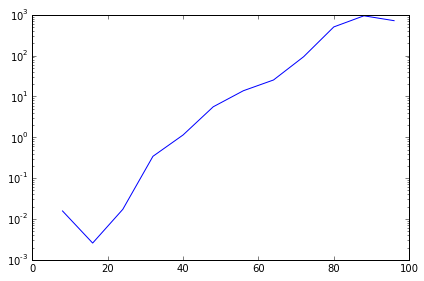

In [22]:
%matplotlib inline
import matplotlib, numpy
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
fig=plt.figure()
plt.plot(keysizes, times)
plt.yscale('log')
fig.tight_layout()


In [10]:
foo.N

2347293817290903099341738590810621775275928061978782446789L

As before, the public key is (e, N) and the private key is (d, N).

In [11]:
foo.e

3

In [12]:
foo.d

1564862544860602066227825727142017115768813211347560431787L

I modified rsa.py to store p, q, and phi(n), so I can dig around the internals of RSA.

In [5]:
foo.phi

55622303509980058401201317471604932276060442074670233879067983748242366318556L

We can quickly verify that e and d are multiplicative inverses in the integers modulo phi(n).

In [6]:
(foo.e * foo.d) % foo.phi

1L

# Encryption

If foo wants to send an encrypted message to bar, he will need bar's public key.

In [23]:
bar = rsa.RSAPrivateKey(128)
barpub = bar.GetPublicKey()

We will prepare a message to send to bar.

In [24]:
m = "Attack at dawn. This is a really long message to see if I can get rsa \
to encode it as more than one number."

Recall from last post that we can only encode numbers smaller than n. If we wish to send a longer message, we need to divide it into smaller pieces and send a sequence. For this we need to know bar's public modulus.

In [25]:
encoded = rsa.Message.Encode(m, barpub.N)
encoded.numbers

[115648799396826751567766945599864979770100194381312838842529118569426414700L,
 214012274130603322894259128424238691739369727293888509978752859858830192160L,
 182685454824088443191059084189136997345550917941544886668325422864334353512L,
 172144231835021845661017141195722362689495106685351054972168510011550466048L]

Now we are ready to compute the cyphertext. This transforms the encoded message into a cyphertext that only bar's private key can decrypt.

In [26]:
c = barpub.Encrypt(encoded)

In [27]:
c.numbers

[15312045657251533996573666661924358169045681847125342761792416520040266208574L,
 25519902372758601831957765798227925694449755591574454493300216816866460554936L,
 33664897869351852965636691119296097528789387994974562564066535337280550171959L,
 3857932400280975337021583394112949884183369908209667710085673982640585490437L]

In [28]:
bar.Decrypt(c).Decode()

'Attack at dawn. This is a really long message to see if I can get rsa to encode it as more than one number.'

# Signatures

A digital signature is just a message that has been encrypted with someone's private key. Thus anyone with the public key can verify that the message comes from the owner of the private key, and that no one has altered the message. 

In [29]:
reply = "This is really bar."
encoded_reply = rsa.Message.Encode(reply, bar.N)
encoded_reply.numbers

[149135777980097582635656205376687025111355119538120755623372731861778300928L]

We have to compute the signature manually, as the rsa module won't let us do it directly.

In [31]:
s = rsa.modexp(encoded_reply.numbers[0], bar.d, bar.N)

In [15]:
s

79482082372224077031364631212447551920995692144876852609977919004935413771073L

If foo receives a message claiming to come from bar, he can use bar's public key to confirm.

In [32]:
verify = encoded_reply
verify.numbers = [rsa.modexp(s, barpub.e, barpub.N)]

In [33]:
plaintext = rsa.Message.Decode(verify)
plaintext

'This is really bar.'

In [34]:
plaintext == reply

True